# Swin Transformer + Shift UNet

1) load a data for a test
2) update a loop for test
3) for each epoch display a training loss , validation loss and test loss + ssim value also

# Data Loading

## Train

In [1]:
X_train_path = '/home/simlab120/Denoise_comp/Pragyant/image-impeccable-train-data-part1/42487393/seismic_w_noise_vol_42487393.npy'
y_train_path = '/home/simlab120/Denoise_comp/Pragyant/image-impeccable-train-data-part1/42487393/seismicCubes_RFC_fullstack_2024.42487393.npy'

## Test

In [2]:
X_test_path = '/home/simlab120/Denoise_comp/Pragyant/image-impeccable-test-data/2024-06-10_0d6402b1/seismic_w_noise_vol_44319345.npy'
y_test_path = '/home/simlab120/Denoise_comp/Pragyant/image-impeccable-train-data-part1/42487919/seismicCubes_RFC_fullstack_2024.42487919.npy'

## Valid

In [3]:
X_valid_path = '/home/simlab120/Denoise_comp/Pragyant/image-impeccable-train-data-part1/42502775/seismic_w_noise_vol_42502775.npy'
y_valid_path = '/home/simlab120/Denoise_comp/Pragyant/image-impeccable-train-data-part1/42502775/seismicCubes_RFC_fullstack_2024.42502775.npy'

In [4]:
shape = (1259,300,300)
# load the data
# make the data in 2d section
# make the train set and test set
# print the image also

In [5]:
import os
import pandas as pd
import numpy as np
from torchvision.io import read_image
from torch.utils.data import Dataset,DataLoader
import torch
# 2 files
# 1259*300*300 ---> 1259*300 in 300 images
# x,y load
# x,y sub sample
# pair
# return
class volDataset(Dataset):
    def __init__(self, x_slices, y_slices, transform=None):
        """
        x_slices: List of noisy seismic slices (each of shape 1259x300)
        y_slices: List of clean seismic slices (each of shape 1259x300)
        """
        self.x_slices = x_slices
        self.y_slices = y_slices
        self.transform = transform

    def __len__(self):
        return len(self.x_slices)

    def __getitem__(self, idx):
        """Returns one slice (1, 1259, 300)"""
        x_slice = torch.tensor(self.x_slices[idx], dtype=torch.float32).unsqueeze(0)  # (1, 1259, 300)
        y_slice = torch.tensor(self.y_slices[idx], dtype=torch.float32).unsqueeze(0)  # (1, 1259, 300)

        if self.transform:
            x_slice = self.transform(x_slice)
            y_slice = self.transform(y_slice)

        return x_slice, y_slice

In [6]:
from sklearn.model_selection import train_test_split
# Convert volume to 2D slices
# Load seismic volumes
X_volume = np.load('/home/simlab120/Denoise_comp/Pragyant/image-impeccable-train-data-part1/42487393/seismic_w_noise_vol_42487393.npy',allow_pickle=True)  # (1259, 300, 300)
y_volume = np.load('/home/simlab120/Denoise_comp/Pragyant/image-impeccable-train-data-part1/42487393/seismicCubes_RFC_fullstack_2024.42487393.npy',allow_pickle=True)  # (1259, 300, 300)

X_volume_t = np.load(X_test_path,allow_pickle=True)
y_volume_t = np.load(y_test_path,allow_pickle=True)

X_volume_v = np.load(X_valid_path,allow_pickle=True)
y_volume_v = np.load(y_valid_path,allow_pickle=True)
# Convert volume to 2D slices

X_slices = [X_volume[:, :, i] for i in range(X_volume.shape[2])]  # List of 300 slices
y_slices = [y_volume[:, :, i] for i in range(y_volume.shape[2])]  # List of 300 slices

X_slices_t = [X_volume_t[:, :, i] for i in range(X_volume_t.shape[2])]
y_slices_t = [y_volume_t[:, :, i] for i in range(y_volume_t.shape[2])]

X_slices_v = [X_volume_v[:, :, i] for i in range(X_volume_v.shape[2])]
y_slices_v = [y_volume_v[:, :, i] for i in range(y_volume_v.shape[2])]

# Create datasets
train_dataset = volDataset(X_slices, y_slices)
valid_dataset = volDataset(X_slices_v,y_slices_v)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(valid_dataset,batch_size=8, shuffle=False)

# Check batch shapes
for x_batch, y_batch in train_loader:
    print("Train Batch Shape:", x_batch.shape, y_batch.shape)  # Expected: (8, 1, 1259, 300)
    break
for x_batch, y_batch in val_loader:
    print("valid Batch Shape:", x_batch.shape, y_batch.shape)  # Expected: (8, 1, 1259, 300)
    break

Train Batch Shape: torch.Size([8, 1, 1259, 300]) torch.Size([8, 1, 1259, 300])
valid Batch Shape: torch.Size([8, 1, 1259, 300]) torch.Size([8, 1, 1259, 300])


# Model

In [7]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [8]:
class Crop2d(nn.Module):
    def __init__(self, left=10, right=10, top=21, bottom=0):
        super(Crop2d, self).__init__()
        self.left = left
        self.right = right
        self.top = top
        self.bottom = bottom

    def forward(self, x):
        return x[:, :, self.top:x.shape[2] - self.bottom, self.left:x.shape[3] - self.right]

In [9]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install segmentation_models_pytorch

Note: you may need to restart the kernel to use updated packages.


In [11]:
import timm
from segmentation_models_pytorch.decoders.unetplusplus import UnetPlusPlus

/home/simlab120/anaconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.models.swin_transformer import Swin_V2_B_Weights

# ---------- Double Convolution Block ----------
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# ---------- Swin UNet Decoder (Fixed) ----------
class SwinUNetDecoder(nn.Module):
    def __init__(self, in_channels=40, n_classes=1):  # ✅ Changed from 128 → 40
        super(SwinUNetDecoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(in_channels, 64, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(64, 64)
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(32, 32)
        self.final_conv = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, x):
        x = self.up1(x)
        x = self.conv1(x)
        x = self.up2(x)
        x = self.conv2(x)
        x = self.final_conv(x)
        return x

# ---------- Swin Transformer + Swin UNet (Fixed) ----------
class SwinUNet(nn.Module):
    def __init__(self):
        super(SwinUNet, self).__init__()
        self.encoder = torchvision.models.swin_v2_b(weights=Swin_V2_B_Weights.IMAGENET1K_V1)
        self.decoder = SwinUNetDecoder(in_channels=40, n_classes=1)  # ✅ Fix input channels

    def forward(self, x):
        if x.shape[1] == 1:  # If input has 1 channel
            x = x.repeat(1, 3, 1, 1)  # Convert (B, 1, H, W) → (B, 3, H, W)

        x = self.encoder.features(x)  # Swin Transformer feature extraction
        x = self.decoder(x)           # Decode using Swin UNet
        x = F.interpolate(x, size=(1259, 300), mode='bilinear')  
        return x


# ---------- Testing ----------
if __name__ == "__main__":
    print("\nTesting SwinUNet Model:")
    model = SwinUNet()
    model.eval()
    x = torch.randn(1, 3, 1259, 300)  # ✅ Input should have 3 channels
    out = model(x)
    print(f"Output shape: {out.shape}")  # Expected: torch.Size([1, 1, 1259, 300])



Testing SwinUNet Model:
Output shape: torch.Size([1, 1, 1259, 300])


In [14]:
pip install torcheval

Note: you may need to restart the kernel to use updated packages.


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim



# Define Loss Function (MSE for denoising)
criterion = nn.MSELoss()

# Define Optimizer (Adam works well)
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [16]:
# Check batch shapes
for x_batch, y_batch in train_loader:
    print("Train Batch Shape:", x_batch.shape, y_batch.shape)  # Expected: (batch_size, 1, 1259, 300)
    break

Train Batch Shape: torch.Size([8, 1, 1259, 300]) torch.Size([8, 1, 1259, 300])


In [17]:
from torchmetrics import StructuralSimilarityIndexMeasure
ssim_metric = StructuralSimilarityIndexMeasure()

/home/simlab120/anaconda3/envs/torch/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


In [18]:
import matplotlib.pyplot as plt

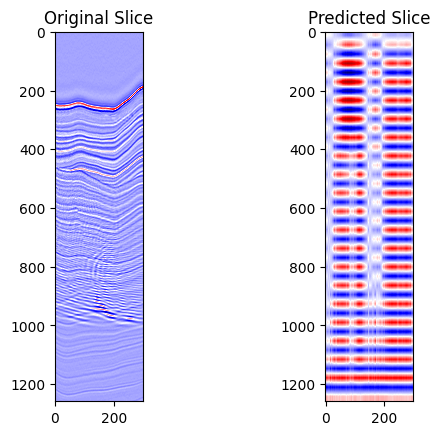

Epoch [1/200], Train Loss: 10076.1285, Train SSIM: 0.4724,           Val Loss: 10148.3007, Val SSIM: 0.3666


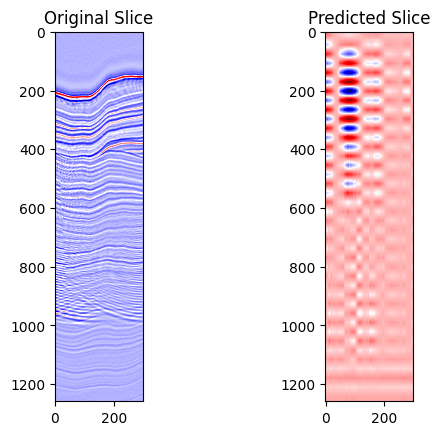

Epoch [2/200], Train Loss: 10056.5490, Train SSIM: 0.4726,           Val Loss: 10101.9151, Val SSIM: 0.4061


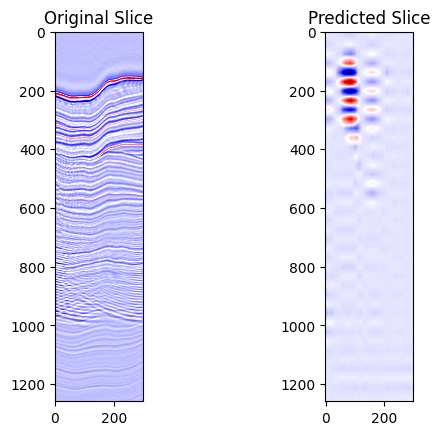

Epoch [3/200], Train Loss: 10055.3509, Train SSIM: 0.4715,           Val Loss: 10097.2727, Val SSIM: 0.4097


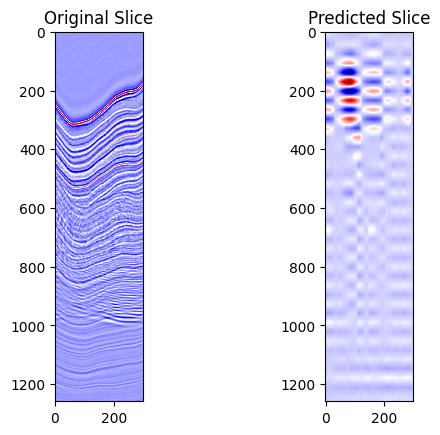

Epoch [4/200], Train Loss: 10057.9312, Train SSIM: 0.4699,           Val Loss: 10105.3715, Val SSIM: 0.4036


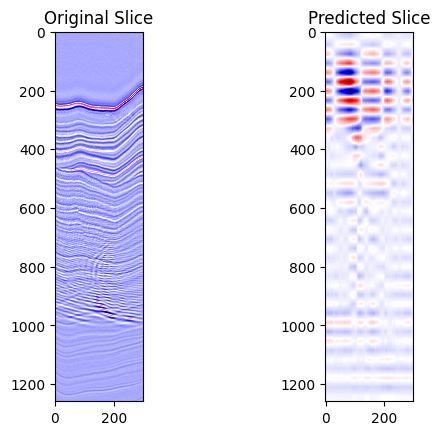

Epoch [5/200], Train Loss: 10064.9105, Train SSIM: 0.4695,           Val Loss: 10111.6009, Val SSIM: 0.3973


KeyboardInterrupt: 

In [19]:
# Number of epochs
num_epochs = 200

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_ssim = 0.0

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch_ssim = ssim_metric(outputs.detach(), y_batch.detach())
        running_ssim += batch_ssim.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_ssim = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            val_outputs = model(x_val)
            val_loss += criterion(val_outputs, y_val).item()
            val_ssim += ssim_metric(val_outputs, y_val).item()

    # Prediction on a single slice from X_slices_t
    random_slice = X_slices_t[torch.randint(0, len(X_slices_t), (1,)).item()]

    # Convert to PyTorch tensor and add batch and channel dimensions
    random_slice = torch.tensor(random_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    prediction = model(random_slice).detach()

    # Visualize the original and predicted slice
    plt.subplot(1, 2, 1)
    plt.title("Original Slice")
    plt.imshow(random_slice.squeeze().cpu().numpy(), cmap='seismic')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Slice")
    plt.imshow(prediction.squeeze().cpu().numpy(), cmap='seismic')
    plt.show()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {running_loss / len(train_loader):.4f}, Train SSIM: {running_ssim / len(train_loader):.4f}, \
          Val Loss: {val_loss / len(val_loader):.4f}, Val SSIM: {val_ssim / len(val_loader):.4f}")


print("Training complete!")
